In [1]:
import sys
import yaml
import numpy as np
from pathlib import Path
import hydra
from hydra import compose, initialize_config_dir
from omegaconf import DictConfig
import os

sys.path.append('../')

In [2]:
from omegaconf import OmegaConf


config_dir = os.path.abspath('../conf')
with initialize_config_dir(config_dir=config_dir, version_base=None):
    cfg = compose(config_name="config")

cfg = OmegaConf.to_container(cfg, resolve=True)
cfg

{'data': {'signal_dim': 2,
  'noise_dim': 100,
  'num_actions': 4,
  'traj_len': 200,
  'step_size': 0.135,
  'n_train': 300,
  'n_val': 30,
  'n_test': 30,
  'seed': 0,
  'out_dir': 'data/'},
 'model': {'z_dim_vae': 2,
  'z_dim_contrastive': 2,
  'enc_widths': [256, 256],
  'dec_widths': [256, 256],
  'proj_widths': [256, 256],
  'dyn_widths': [256, 256],
  'probe_widths': [64, 64],
  'activation': 'relu'},
 'train': {'batch_size': 256,
  'epochs_phase1': 10,
  'epochs_phase2': 10,
  'epochs_probe': 10,
  'num_workers': 0,
  'ckpt_dir': 'ckpts/',
  'eval_batch_size': 512,
  'wandb_log_freq': 200,
  'device': 'mps',
  'vae': {'lr': 0.002, 'weight_decay': 0.0, 'beta': 0.001},
  'contrastive': {'lr': 0.001, 'weight_decay': 0.0, 'temperature': 0.1},
  'dynamics': {'lr': 0.001, 'weight_decay': 0.0},
  'probe': {'lr': 0.001, 'weight_decay': 0.0}},
 'wandb': {'enabled': True,
  'project': 'repr-world',
  'entity': 'mattia-scardecchia',
  'group': None,
  'mode': 'online',
  'dir': 'logs',
  

In [3]:
from scripts.generate_data import main as gen_main

gen_main(cfg)

Wrote data/train.npz with shapes s(60000, 102), a(60000,), sp(60000, 102)
Wrote data/val.npz with shapes s(6000, 102), a(6000,), sp(6000, 102)
Wrote data/test.npz with shapes s(6000, 102), a(6000,), sp(6000, 102)


## Quick data exploration

train shapes: (60000, 102) (60000,) (60000, 102)
state mean/std: 0.00085907365 0.9995189
signal mean/std: 0.028921427 0.99126464
noise mean/std: 0.0002978269 0.9996753
actions min/max/unique: 0 3 (array([0, 1, 2, 3]), array([15118, 14927, 14967, 14988]))


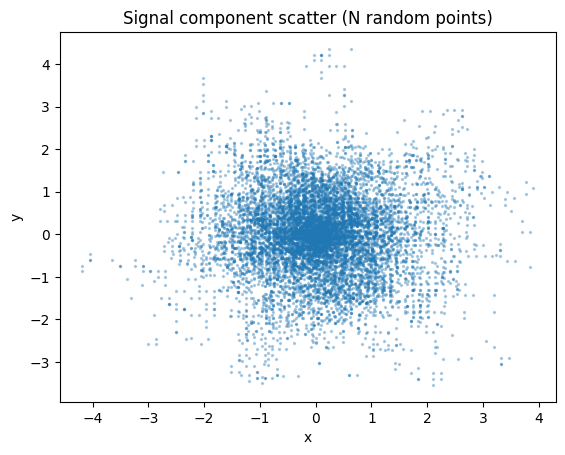

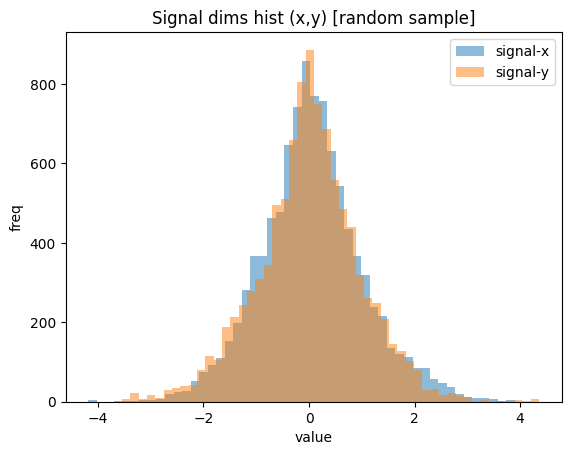

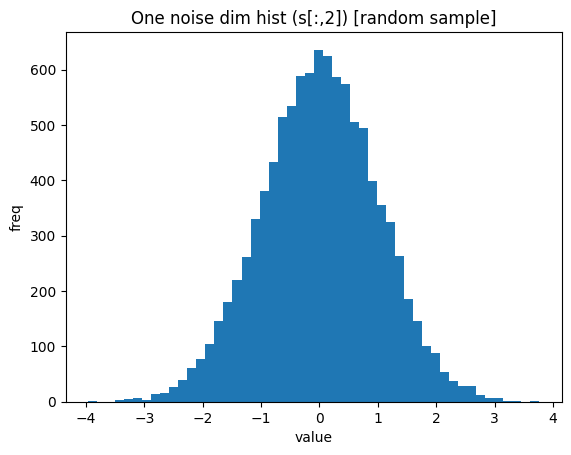

In [4]:
import matplotlib.pyplot as plt

data_dir = Path(cfg['data']['out_dir'])
train = np.load(data_dir / 'train.npz')
val = np.load(data_dir / 'val.npz')
test = np.load(data_dir / 'test.npz')

s, a, sp = train['s'], train['a'], train['sp']
print("train shapes:", s.shape, a.shape, sp.shape)

print("state mean/std:", s.mean(), s.std())
print("signal mean/std:", s[:,0:2].mean(), s[:,0:2].std())
print("noise mean/std:", s[:,2:].mean(), s[:,2:].std())
print("actions min/max/unique:", a.min(), a.max(), np.unique(a, return_counts=True))

N = min(10000, s.shape[0])
idx = np.random.choice(s.shape[0], N, replace=False)

plt.figure()
plt.scatter(s[idx,0], s[idx,1], s=2, alpha=0.3)
plt.title("Signal component scatter (N random points)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.figure()
plt.hist(s[idx,0], bins=50, alpha=0.5, label='signal-x')
plt.hist(s[idx,1], bins=50, alpha=0.5, label='signal-y')
plt.title("Signal dims hist (x,y) [random sample]")
plt.xlabel("value")
plt.ylabel("freq")
plt.legend()
plt.show()

plt.figure()
plt.hist(s[idx,2], bins=50)
plt.title("One noise dim hist (s[:,2]) [random sample]")
plt.xlabel("value")
plt.ylabel("freq")
plt.show()

In [5]:
# The signal has a quasi-gaussian histogram. The best non-parametric guess for reconstruction is the mean.
# MSE of that guess is the variance.

((s[:, :2] - s[:, :2].mean(axis=0))**2).mean()

np.float32(1.6275393)

In [6]:
# Same applies to the noise dimensions.
# Global MSE:

((s[:, :] - s[:, :].mean(axis=0))**2).mean()

np.float32(1.0116515)

## Train Phase 1 (choose one)

In [7]:
from scripts.train import train_phase1_contrastive, train_phase1_vae, _maybe_init_wandb

device = 'mps'
z_space = 'vae'
wb = _maybe_init_wandb(cfg)

assert z_space == 'vae'
enc_path, vae_metrics = train_phase1_vae(cfg, device, wb)
print("VAE training metrics:", vae_metrics)

wandb: Currently logged in as: mattia-scardecchia to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training VAE. Epochs: 10; Batch size: 256; Steps per epoch: 235.


/Users/mat/anaconda3/envs/toy/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[VAE] Epoch 1: train_loss=0.9906, train_recon=0.9887, train_kl=1.9608
[VAE-VAL] Epoch 1: val_loss=0.9839, val_recon=0.9819, val_kl=1.9232
[VAE] Epoch 2: train_loss=0.9828, train_recon=0.9807, train_kl=2.1564
[VAE-VAL] Epoch 2: val_loss=0.9829, val_recon=0.9808, val_kl=2.0806
[VAE] Epoch 2: train_loss=0.9828, train_recon=0.9807, train_kl=2.1564
[VAE-VAL] Epoch 2: val_loss=0.9829, val_recon=0.9808, val_kl=2.0806
[VAE] Epoch 3: train_loss=0.9817, train_recon=0.9794, train_kl=2.2566
[VAE-VAL] Epoch 3: val_loss=0.9820, val_recon=0.9798, val_kl=2.2173
[VAE] Epoch 3: train_loss=0.9817, train_recon=0.9794, train_kl=2.2566
[VAE-VAL] Epoch 3: val_loss=0.9820, val_recon=0.9798, val_kl=2.2173
[VAE] Epoch 4: train_loss=0.9810, train_recon=0.9786, train_kl=2.3552
[VAE-VAL] Epoch 4: val_loss=0.9823, val_recon=0.9802, val_kl=2.1531
[VAE] Epoch 4: train_loss=0.9810, train_recon=0.9786, train_kl=2.3552
[VAE-VAL] Epoch 4: val_loss=0.9823, val_recon=0.9802, val_kl=2.1531
[VAE] Epoch 5: train_loss=0.9805, 

## Train Phase 2 dynamics (on selected latent space)

In [ ]:
from scripts.train import train_phase2_dynamics

dyn_path, dynamics_metrics = train_phase2_dynamics(cfg, device, repr_method=z_space, wb=wb)
print("Dynamics training metrics:", dynamics_metrics)
dyn_path

[DYN-VAE] Epoch 1: train_mse=0.5703
[DYN-VAE-VAL] Epoch 1: val_mse=0.4547
[DYN-VAE] Epoch 2: train_mse=0.5465
[DYN-VAE-VAL] Epoch 2: val_mse=0.4490
[DYN-VAE] Epoch 2: train_mse=0.5465
[DYN-VAE-VAL] Epoch 2: val_mse=0.4490
[DYN-VAE] Epoch 3: train_mse=0.5436
[DYN-VAE-VAL] Epoch 3: val_mse=0.4617
[DYN-VAE] Epoch 3: train_mse=0.5436
[DYN-VAE-VAL] Epoch 3: val_mse=0.4617
[DYN-VAE] Epoch 4: train_mse=0.5417
[DYN-VAE-VAL] Epoch 4: val_mse=0.4636
[DYN-VAE] Epoch 4: train_mse=0.5417
[DYN-VAE-VAL] Epoch 4: val_mse=0.4636
[DYN-VAE] Epoch 5: train_mse=0.5403
[DYN-VAE-VAL] Epoch 5: val_mse=0.4516
[DYN-VAE] Epoch 5: train_mse=0.5403
[DYN-VAE-VAL] Epoch 5: val_mse=0.4516
[DYN-VAE] Epoch 6: train_mse=0.5390
[DYN-VAE-VAL] Epoch 6: val_mse=0.4638
[DYN-VAE] Epoch 6: train_mse=0.5390
[DYN-VAE-VAL] Epoch 6: val_mse=0.4638
[DYN-VAE] Epoch 7: train_mse=0.5388
[DYN-VAE-VAL] Epoch 7: val_mse=0.4531
[DYN-VAE] Epoch 7: train_mse=0.5388
[DYN-VAE-VAL] Epoch 7: val_mse=0.4531
[DYN-VAE] Epoch 8: train_mse=0.5384
[D

'ckpts/dyn_vae.pt'

## Train probe on frozen latents (z → R^2)

In [ ]:
from scripts.train import train_probes
probe_path, probe_metrics = train_probes(cfg, device, repr_method=z_space, wb=wb)
print("Probe training metrics:", probe_metrics)
probe_path

[PROBE-VAE] Epoch 1: train_mse=0.5085
[PROBE-VAE-VAL] Epoch 1: val_mse=0.3703
[PROBE-VAE] Epoch 2: train_mse=0.3678
[PROBE-VAE-VAL] Epoch 2: val_mse=0.3550
[PROBE-VAE] Epoch 2: train_mse=0.3678
[PROBE-VAE-VAL] Epoch 2: val_mse=0.3550
[PROBE-VAE] Epoch 3: train_mse=0.3574
[PROBE-VAE-VAL] Epoch 3: val_mse=0.3640
[PROBE-VAE] Epoch 3: train_mse=0.3574
[PROBE-VAE-VAL] Epoch 3: val_mse=0.3640
[PROBE-VAE] Epoch 4: train_mse=0.3526
[PROBE-VAE-VAL] Epoch 4: val_mse=0.3708
[PROBE-VAE] Epoch 4: train_mse=0.3526
[PROBE-VAE-VAL] Epoch 4: val_mse=0.3708
[PROBE-VAE] Epoch 5: train_mse=0.3502
[PROBE-VAE-VAL] Epoch 5: val_mse=0.3592
[PROBE-VAE] Epoch 5: train_mse=0.3502
[PROBE-VAE-VAL] Epoch 5: val_mse=0.3592
[PROBE-VAE] Epoch 6: train_mse=0.3486
[PROBE-VAE-VAL] Epoch 6: val_mse=0.3714
[PROBE-VAE] Epoch 6: train_mse=0.3486
[PROBE-VAE-VAL] Epoch 6: val_mse=0.3714
[PROBE-VAE] Epoch 7: train_mse=0.3484
[PROBE-VAE-VAL] Epoch 7: val_mse=0.3628
[PROBE-VAE] Epoch 7: train_mse=0.3484
[PROBE-VAE-VAL] Epoch 7: v

'ckpts/probe_vae.pt'

## Evaluate end-to-end next-signal MSE

In [10]:
from scripts.eval import evaluate
eval_metrics = evaluate(cfg, z_space, device)
print("Evaluation metrics:", eval_metrics)

[EVAL-vae] next-signal MSE = 0.530017
Evaluation metrics: {'final_eval_loss': 0.5300166204770406}
